In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.stats as ss
import scipy.special as sp
import theano
import pymc3 as pm

In [4]:
pm.__version__

'3.8'

In [5]:
# We begin reading the data into a pandas dataframe.
cookies = pd.read_csv('/home/xavier/Documents/research/FORMANRISK/data/data_formanrisk/cookies.dat', sep=' ')
cookies.shape

(150, 2)

In [6]:
model = pm.Model()

with model:
    
    # Prior distribution for mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    
    # Prior distribution for sigma2.
    sigma = pm.Exponential('sigma', 1.0)
    
    # Parametrization for the shape parameter.
    alpha =  mu**2/sigma**2
    
    # Parametrization for the scale parameter.
    beta = mu/sigma**2
    
    # Prior distribution for lambda.
    lam = pm.Gamma(
        'lam', 
        alpha=alpha, 
        beta=beta, 
        shape=cookies.location.values.max()
    )
    
    # Likelihood function for the data.
    chips = [
        pm.Poisson('chips_{}'.format(i),lam[i], 
        observed=cookies[cookies.location==i+1].chips.values) 
        for i in range(cookies.location.values.max())
    ] 
    
    # Parameters of the simulation:
    # Number of iterations and independent chains.
    n_draws, n_chains = 1000, 3
    
    n_sim = n_draws*n_chains
    
    trace = pm.sample(draws=n_draws, chains=n_chains) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [lam, sigma, mu]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:01<00:00, 2793.99draws/s]


/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backend

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>]], dtype=object)

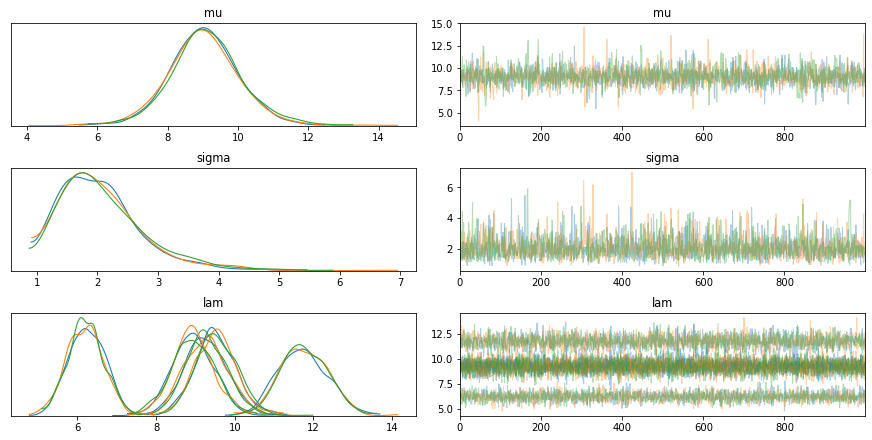

In [7]:
pm.traceplot(trace)

# Real data

In [100]:
# We begin reading the data into a pandas dataframe.
df = pd.read_csv('/home/xavier/Documents/research/FORMANRISK/analyse/forman_cavit/output/table/df_PP.csv', 
                 index_col=0)
df.shape

(352, 64)

In [101]:
df.columns

Index(['index', 'Species', 'site', 'Treatment', 'P50', 'P12', 'P88', 'slope',
       'Kmax', 'P50e', 'P12e', 'P88e', 'slopee', 'Kmaxe', 'branch_diame', 'x',
       'y', 'Tmean_annual', 'Mean_D_range', 'Isothermality', 'T_seasonality',
       'Tmax_warmerM', 'Tmin_coldestM', 'T_annual_range', 'Tmean_wettestQ',
       'Tmean_driestQ', 'Tmean_warmerQ', 'Tmean_coldestQ', 'P_annual',
       'P_wettestM', 'P_driestM', 'P_seasonality', 'P_wettestQ', 'P_driestQ',
       'P_warmestQ', 'P_coldestQ', 'Country', 'elevation.m.', 'species_2',
       'sapling.age.yr..height.m.', 'adult.age.yr..height.m.',
       'sampling.dates', 'person.in.charge', 'email', 'info', 'acp_0', 'acp_1',
       'acp_2', 'acp_3', 'acp_4', 'acp_5', 'acp_6', 'acp_7', 'acp_8', 'acp_9',
       'acp_10', 'acp_11', 'acp_12', 'acp_13', 'acp_14', 'acp_15', 'acp_16',
       'acp_17', 'acp_18'],
      dtype='object')

In [102]:
df.head()

,index,Species,site,Treatment,P50,P12,P88,slope,Kmax,P50e,...,acp_9,acp_10,acp_11,acp_12,acp_13,acp_14,acp_15,acp_16,acp_17,acp_18
0,0,pinus pinaster,biscarrosse,adult,-3.818704,-3.358275,-4.279133,108.594361,0.000249,NaN,...,-0.014667,0.023593,2.298899e-14,2.924778e-15,1.067688e-15,-1.940067e-16,6.183864e-16,-8.333598e-16,2.113119e-16,6.296274e-17
1,1,pinus pinaster,biscarrosse,adult,-3.855426,-3.378376,-4.332476,104.810817,0.001174,NaN,...,-0.014667,0.023593,-5.123766e-15,1.262076e-14,1.566052e-15,-6.654425e-16,-1.497236e-15,4.468820e-16,-2.394879e-16,1.003908e-16
2,2,pinus pinaster,biscarrosse,adult,-3.198479,-1.852982,-4.543976,37.160995,0.000166,NaN,...,-0.014667,0.023593,3.244012e-15,-4.837487e-15,5.518892e-15,-2.041714e-15,-2.938985e-15,1.663625e-15,-4.066808e-16,1.238951e-16
3,3,pinus pinaster,biscarrosse,adult,-3.969812,-3.138009,-4.801616,60.110348,0.000649,NaN,...,-0.014667,0.023593,1.493739e-15,5.141385e-16,-2.936243e-15,-2.975215e-15,3.142911e-15,2.378543e-15,-2.589680e-16,4.223454e-16
4,4,pinus pinaster,biscarrosse,adult,-3.690672,-2.621588,-4.759757,46.769004,0.000316,NaN,...,-0.014667,0.023593,-2.960995e-16,-1.282696e-15,-1.806558e-15,2.321956e-15,-7.398805e-16,-6.021022e-16,-1.502683e-15,1.199881e-15


In [103]:
dummies.columns = ['adult','young']
df = pd.concat([df, dummies], axis=1)
df.head()


,index,Species,site,Treatment,P50,P12,P88,slope,Kmax,P50e,...,acp_11,acp_12,acp_13,acp_14,acp_15,acp_16,acp_17,acp_18,adult,young
0,0,pinus pinaster,biscarrosse,adult,-3.818704,-3.358275,-4.279133,108.594361,0.000249,NaN,...,2.298899e-14,2.924778e-15,1.067688e-15,-1.940067e-16,6.183864e-16,-8.333598e-16,2.113119e-16,6.296274e-17,1,0
1,1,pinus pinaster,biscarrosse,adult,-3.855426,-3.378376,-4.332476,104.810817,0.001174,NaN,...,-5.123766e-15,1.262076e-14,1.566052e-15,-6.654425e-16,-1.497236e-15,4.468820e-16,-2.394879e-16,1.003908e-16,1,0
2,2,pinus pinaster,biscarrosse,adult,-3.198479,-1.852982,-4.543976,37.160995,0.000166,NaN,...,3.244012e-15,-4.837487e-15,5.518892e-15,-2.041714e-15,-2.938985e-15,1.663625e-15,-4.066808e-16,1.238951e-16,1,0
3,3,pinus pinaster,biscarrosse,adult,-3.969812,-3.138009,-4.801616,60.110348,0.000649,NaN,...,1.493739e-15,5.141385e-16,-2.936243e-15,-2.975215e-15,3.142911e-15,2.378543e-15,-2.589680e-16,4.223454e-16,1,0
4,4,pinus pinaster,biscarrosse,adult,-3.690672,-2.621588,-4.759757,46.769004,0.000316,NaN,...,-2.960995e-16,-1.282696e-15,-1.806558e-15,2.321956e-15,-7.398805e-16,-6.021022e-16,-1.502683e-15,1.199881e-15,1,0


In [107]:
Y = df.P50.values
X1 = df.acp_0.values
X2 = df.acp_1.values

X3 = df.adult.values
X4 = df.young.values

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=-3.8, sigma=100)
    beta1 = pm.Normal("beta1", mu=0, sigma=100, shape = 2)
    
    beta2 = pm.Normal("beta2", mu=0, sigma=100, shape = 2)
    
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = alpha + beta1[0]*X1 + beta1[1]*X2 + beta2[0]*X3 + beta2[1]*X4

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [110]:
with basic_model:
    # draw 500 posterior samples
    n_draws, n_chains = 1000, 3    
    n_sim = n_draws*n_chains    
    trace = pm.sample(tune = 1000, draws=n_draws, chains=n_chains) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, beta2, beta1, alpha]
Sampling 3 chains, 306 divergences: 100%|██████████| 6000/6000 [03:35<00:00, 27.80draws/s] 
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9147187618531378, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.13494489575918464, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 2

/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/xavier/anaconda3/envs/mcmc/lib/python3.8/site-packages/arviz/plots/backend

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

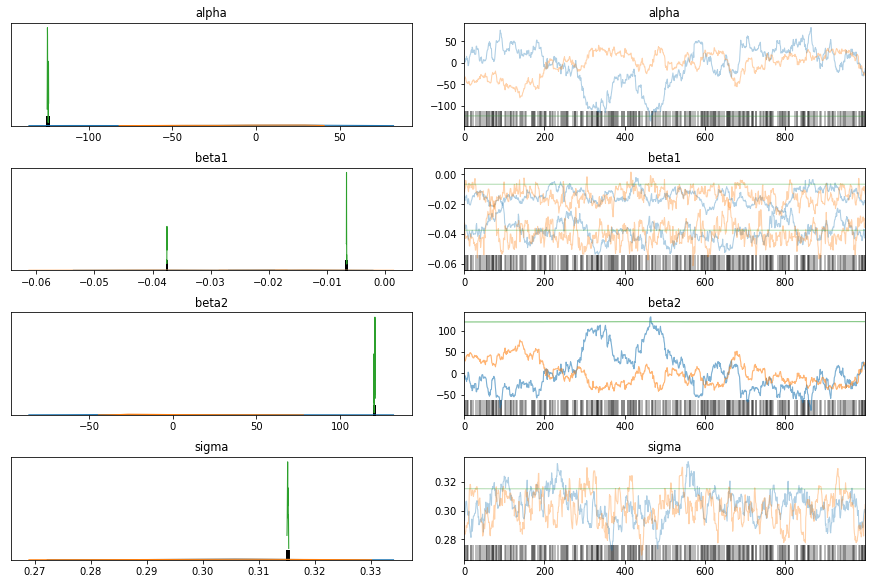

In [111]:
pm.traceplot(trace)

In [56]:
trace["alpha"][-5:]

array([-3.84654266, -3.75611422, -3.87255625, -3.82885949, -3.78877387])

In [60]:
trace["beta"][-5:]

array([[-0.01338112, -0.04081693],
       [-0.01279535, -0.03846989],
       [-0.00827288, -0.04286155],
       [-0.01303499, -0.03889984],
       [-0.01172986, -0.04168222]])

In [54]:
# Convert X and Y to a pandas DataFrame
df_glm = pd.DataFrame({"x1": df.acp_0.values, "x2": df.acp_1.values, "x3": df.Treatment.values, "y": df.P50.values})

In [55]:
from pymc3.glm import GLM
with pm.Model() as model_glm:
    GLM.from_formula("y ~ x1 + x2 + x3", df_glm)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x2, x1, x3[T.young], Intercept]

Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

ValueError: Not enough samples to build a trace.

In [ ]:
pm.traceplot(trace)